In [1]:
LEARNING_TYPE = "pointwise"
MODEL_CLASS = "CDAE"
DATA_NAME = "movielens"
MODEL_NAME = f"{MODEL_CLASS}_{DATA_NAME}"

In [2]:
WORK_DIR_PATH = "../.."

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# WORK_DIR_PATH = "/content/drive/MyDrive/RS-CDAE/"

# Constants

In [4]:
# split
TRN_NEG_PER_POS = 5
TST_NEG_PER_POS = None
TRN_BATCH_SIZE = 128
TST_BATCH_SIZE = TRN_BATCH_SIZE
TRN_VAL_TST_RATIO = dict(trn=0.8, val=0.1, tst=0.1)
NEG_PER_POS_RATIO = dict(trn=TRN_NEG_PER_POS, val=TRN_NEG_PER_POS, tst=TST_NEG_PER_POS)
BATCH_SIZE = dict(trn=TRN_BATCH_SIZE, val=TRN_BATCH_SIZE, tst=TST_BATCH_SIZE)
SHUFFLE = True

In [5]:
# Model
N_FACTORS = 50
DROPOUT = 0.5

In [6]:
# how to learn
TASK_FN_TYPE = "bce"
LEARNING_RATE = 1e-3
LAMBDA_ = 1e-6

In [7]:
# how to loop
N_EPOCHS = 1000

# Config

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\PAPER REVIEW\RECSYS\03_AE\RS-CDAE


In [10]:
import pandas as pd
import torch
from CDAE import cdae
import UTILS
from DATA_SPLITTER.trn_val_tst import TRN_VAL_TST
from LOOP.loop import TrainingLoop
from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
from LOOP.predictor.predictor import PerformancePredictor
from LOOP.evaluator.evaluator import PerformanceEvaluator

In [11]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [12]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [13]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [14]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [15]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [16]:
# data Description
UTILS.datahandler.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
max interaction of item: 329
top 10.0 % interaction of user: 400.3
top 10.0 % interaction of item: 27.0
mean interaction of user: 165
mean interaction of item: 10


In [17]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
)

dataloader = TRN_VAL_TST(**kwargs)

In [18]:
kwargs = dict(
    origin=data,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos_ratio=NEG_PER_POS_RATIO,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE,
)

loaders = dataloader.get(**kwargs)

In [19]:
trn_loader, val_loader, tst_loader = loaders

# Modeling

In [20]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    dropout=DROPOUT,
)

model = cdae.model.Module(**kwargs)

In [21]:
kwargs = dict(
    model=model,
    task_fn_type=TASK_FN_TYPE,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [22]:
kwargs = dict(
    model=model,
    trainer=trainer,
)

loop = TrainingLoop(**kwargs)

# Train

In [23]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    n_epochs=N_EPOCHS,
)

history = loop.fit(**kwargs)

COMPUTING COST FOR LEARNING
	(s/epoch): 0.0591
	(epoch/s): 16.9200
	(s/batch): 0.0118
	(batch/s): 84.6000


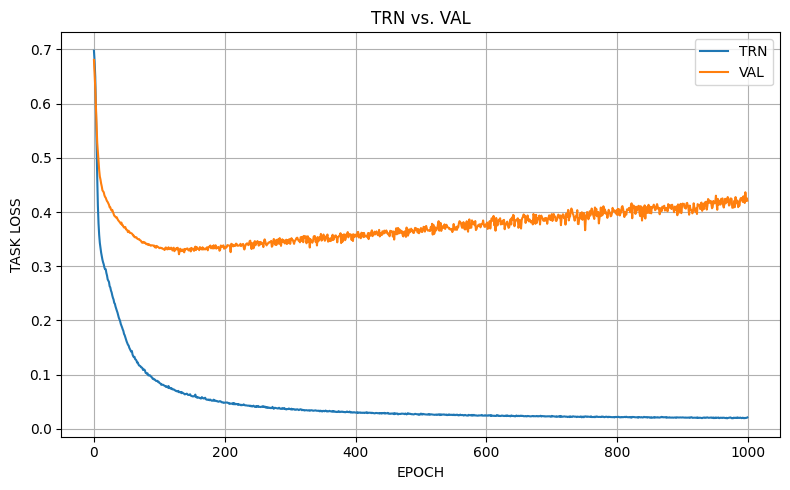

In [24]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [25]:
predictor = PerformancePredictor(model)

In [26]:
result = predictor.predict(tst_loader)

COMPUTING COST FOR INFERENCE
	(s/epoch): 0.0215
	(epoch/s): 46.5038
	(s/batch): 0.0043
	(batch/s): 232.5192


In [27]:
evaluator = PerformanceEvaluator()

In [28]:
eval = evaluator.evaluate(result)
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.585246,0.246557,0.106988,0.069212,0.267410
1,10,0.713115,0.208689,0.188479,0.094509,0.266244
2,15,0.768852,0.180984,0.245088,0.108439,0.270949
3,20,0.816393,0.162623,0.292150,0.117467,0.278841
4,25,0.836066,0.147475,0.324019,0.123030,0.284298
5,50,0.888525,0.102590,0.423323,0.137223,0.305753
6,100,0.939344,0.069262,0.539933,0.147737,0.339736


# Save

In [29]:
PATH = f'./_checkpoints/{LEARNING_TYPE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)